In [106]:
from noise_generator import generate_noise_trajectory, monte_carlo_noise
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import SNAIL, composite_sys, calculate_floquet_energies
import scqubits

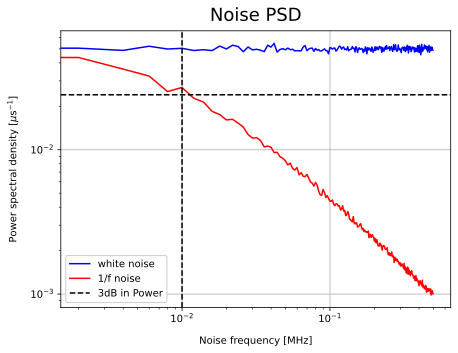

Checking definitions: 
Median PSD/ (Defined noise strength * t_max): 0.9993547857006394
Std dev of frequency shifts / Square-root of (noise strength * t_max): 0.980583584808153


In [107]:
# Set parameters
sample_rate = 1                      # per us
t_max = 500                          # in us
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 1000             # Number of Monte-Carlo trajectories
# Try white noise
t_list, trajectories_list, freq_list, white_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=True)

white_noise_psd = np.mean(white_noise_psds, axis=0)

# Try 1/f noise
tlist, trajectories_list, freq_list, lowfreq_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0=1e-2, white=False)

lowfreq_noise_psd = np.mean(lowfreq_noise_psds, axis=0)

# Plot of power spectral density
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10, size=18)
plt.loglog(freq_list, white_noise_psd, 'b', label="white noise")
plt.loglog(freq_list, lowfreq_noise_psd, 'r', label="1/f noise")
plt.axvline(x = f0, color='black', linestyle='dashed') 
plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r"Power spectral density [$\mu$s$^{-1}$]", labelpad=12)
plt.xlabel("Noise frequency [MHz]", labelpad=12)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

print('Checking definitions: ')
print('Median PSD/ (Defined noise strength * t_max): '+str(np.median(white_noise_psd)/(relative_PSD_strength * t_max)))
print('Std dev of frequency shifts / Square-root of (noise strength * t_max): '+str( (np.std(trajectories_list, axis=0)[-1]) / (np.sqrt(relative_PSD_strength * t_max)) ))

In [116]:
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-5
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)
    

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = np.abs(eigenvectors[i, :])
            max_index = np.argmax(max_abs_vals)
            while max_index in sorted_indices:
                max_abs_vals[max_index] = -np.inf
                max_index = np.argmax(max_abs_vals)
            sorted_indices.append(max_index)

        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        return sorted_eigenvalues, sorted_eigenvectors

    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.H = self.H[:self.total_dim, :self.total_dim]
        self.H_control = self.H_control[:self.total_dim, :self.total_dim]
        
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        self.H_per = H
        self.H_control_per = H_control
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]
        self.H_per = self.H_per[:self.total_dim, :self.total_dim]
        self.H_control_per = self.H_control_per[:self.total_dim, :self.total_dim]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise = (H_per - H) / self.epsilon
        self.noise = self.noise[:self.total_dim, :self.total_dim]

    def get_sigmax(self):
        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmax = np.kron(np.eye(self.sdim), cavity_sigmax)
        sigmax = sigmax[:self.total_dim, :self.total_dim]
        return sigmax

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        der2 = (energy02_ - energy01_ - (energy02 - energy01)) / self.epsilon
        der3 = (energy03_ - energy02_ - (energy03 - energy02)) / self.epsilon
        return self.static_rate(der1)
        
        
    

In [153]:
from scipy.optimize import minimize
import numpy as np

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)

A = 1e-3 * 2 * np.pi

# Define the objective function to minimize
def objective(omega_d):
    dr = sc.calculate_dr_exact(A, omega_d)
    # Take the absolute value to ensure we return a real number
    return np.abs(dr)

# Initial guess for omega_d
initial_guess = 6.2 * 2 * np.pi

# Perform the optimization
result = minimize(objective, initial_guess, method='Nelder-Mead')

# Extract the optimized omega_d
optimized_omega_d = result.x[0]

# Print the optimized omega_d and the minimum value
print(f"Optimized omega_d: {optimized_omega_d / (2 * np.pi):.3f} MHz")
print(f"Minimum value: {result.fun:.3e}")

TypeError: The coefficient function must return a number

In [146]:
from joblib import Parallel, delayed

def _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, sigmax, sc):
    t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    noise_op = qt.Qobj(sc.noise)
    H_tot = [H0, [noise_op, shifts]]
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=[sigmax])
    return shifts, result.expect[0], psd, t_list, freq_list

def monte_carlo_squid(detuning=0.0, num_realizations=1000, sample_rate=1, t_max=200, 
                     relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, n_jobs=50):
    N = int(sample_rate*t_max) + 1
    trajectories_list = np.zeros((num_realizations, N))
    trunc = [5,3]
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    sc = Hamiltonian(phi_ex, Ej, Ec, trunc)
    H0 = qt.Qobj(sc.H)
    init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
    sigmax = qt.Qobj(sc.get_sigmax())
    
    # Parallel computation of trajectories
    results = Parallel(n_jobs=n_jobs)(
        delayed(_single_trajectory)(
            idx, sample_rate, t_max, relative_PSD_strength, f0, white,
            H0, init_state, sigmax, sc
        ) for idx in range(num_realizations)
    )
    
    # Unpack results
    Xtraj_list = np.zeros((num_realizations, N))
    noise_psd = np.zeros(N//2)
    
    for idx, (shifts, expect, psd, t_list, freq_list) in enumerate(results):
        trajectories_list[idx] = shifts
        Xtraj_list[idx] = expect
        noise_psd += psd
    
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [147]:
# Try 1/f noise
# Set parameters
sample_rate = 1                       # per us
t_max = 200                           # in us
relative_PSD_strength = (20/100.)**2  # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = (1./100.)                        # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 1000               # Number of Monte-Carlo trajectories
detuning = 0                      # Ramsey detuning in units of us^-1
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)


Fitted gamma: 0.009914944942339401
Fitted w: 32.75848083469869


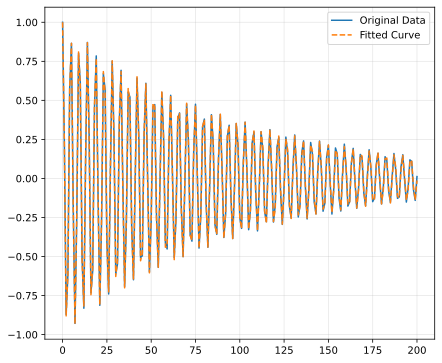

In [148]:
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq, p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, mean_Xtraj_lowfreq, label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from joblib import Parallel, delayed

def _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, sigmax, sc):
    t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    noise_op = qt.Qobj(sc.noise)
    H_tot = [H0, [noise_op, shifts]]
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=[sigmax])
    return shifts, result.expect[0], psd, t_list, freq_list

def monte_carlo_squid(detuning=0.0, num_realizations=1000, sample_rate=1, t_max=200, 
                     relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, n_jobs=50):
    N = int(sample_rate*t_max) + 1
    trajectories_list = np.zeros((num_realizations, N))
    
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    sc = Hamiltonian(phi_ex, Ej, Ec, [4,3])
    H0 = qt.Qobj(sc.H)
    init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
    sigmax = qt.Qobj(sc.get_sigmax())
    
    # Parallel computation of trajectories
    results = Parallel(n_jobs=n_jobs)(
        delayed(_single_trajectory)(
            idx, sample_rate, t_max, relative_PSD_strength, f0, white,
            H0, init_state, sigmax, sc
        ) for idx in range(num_realizations)
    )
    
    # Unpack results
    Xtraj_list = np.zeros((num_realizations, N))
    noise_psd = np.zeros(N//2)
    
    for idx, (shifts, expect, psd, t_list, freq_list) in enumerate(results):
        trajectories_list[idx] = shifts
        Xtraj_list[idx] = expect
        noise_psd += psd
    
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd